In [111]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from routines.models import get_pipe_base
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.kernel_approximation import RBFSampler, Nystroem
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from routines.models import get_balanced_sample_weights, ks_test_d, ks_test_p
from sklearn.metrics import make_scorer, matthews_corrcoef, fbeta_score, classification_report, roc_auc_score, f1_score, log_loss
from time import time
from routines.transformers import SparseTransformer
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import norm as sp_norm
from routines.evals_n_plots import get_cv_res_df, plot_cv_res_df, plot_permut_hist, plot_learning_curve, \
    plot_multi_metric_cv, plot_confusion_matrix, plot_roc_curve, plot_prc_curve
from sklearn.model_selection import permutation_test_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from scipy.stats import ks_2samp
import pickle
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

### Set params

In [2]:
random_state: int = 42
sample_test_size: float = 0.20
max_jobs: int = 2
pre_dispatch = 2
outer_cv: int = 5
inner_cv: int = 3

### Load training set

In [3]:
df = pd.read_csv('src/Train_Sample.csv', sep=';', index_col=0)
y = df['Status']
X = df.drop(labels='Status', axis=1, inplace=False)
del df
print('X.shape: {0}\ty.shape: {1}'.format(X.shape, y.shape))

X.shape: (65974, 221)	y.shape: (65974,)


### Split training set into train-test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=sample_test_size,
                                                    random_state=random_state,
                                                    stratify=y)
print('X_train.shape: {0}\ty_train.shape: {1}\n'
      'X_test.shape: {2}\ty_test.shape: {3}\n'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape: (52779, 221)	y_train.shape: (52779,)
X_test.shape: (13195, 221)	y_test.shape: (13195,)



### Load base pipe (extract base features)

In [5]:
corr_threshold = 0.90
var_threshold = (0.98 * (1.00 - 0.98))

pipe_base = get_pipe_base(random_state=random_state, corr_threshold=corr_threshold, var_threshold=var_threshold)
# pipe_base

### Fit RF w calibration

In [59]:
pipe_calib_rf = Pipeline(steps=[('pipe_base', pipe_base),
                                ('smote', SMOTE(ratio='auto',
                                                kind='regular',
                                                n_jobs=max_jobs,
                                                random_state=random_state)),
                                ('random_forest_calibrated', CalibratedClassifierCV(
                                    base_estimator=RandomForestClassifier(random_state=random_state,
                                                                          n_jobs=max_jobs,
                                                                          criterion='entropy',
                                                                          class_weight='balanced_subsample',
                                                                          bootstrap=True,
                                                                          oob_score=False,
                                                                          n_estimators=300,
                                                                          max_features='sqrt',
                                                                          max_depth=None,
                                                                          min_samples_leaf=1,
                                                                          min_impurity_decrease=0.0095, ),
                                    cv=5, method='isotonic')),
                                ],
                         # memory='pipe_cache/'
                         )

In [60]:
t0 = time()
pipe_calib_rf.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))

Predict Time:  201.70497965812683


In [63]:
pipe_calib_rf.named_steps['random_forest_calibrated'].cv

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0095,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=2, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
            cv=5, method='isotonic')

In [65]:
t0 = time()
calib_rf_pred_train = pipe_calib_rf.predict(X_train)
calib_rf_pred_test = pipe_calib_rf.predict(X_test)
calib_rf_proba_train = pipe_calib_rf.predict_proba(X_train)
calib_rf_proba_test = pipe_calib_rf.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  17.134246349334717


In [81]:
print('#TRAIN RF CALIBRATED#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, calib_rf_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=calib_rf_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, calib_rf_pred_train),
                ks_2samp(y_train, calib_rf_pred_train)[0],
                ks_2samp(y_train, calib_rf_pred_train)[1],
                log_loss(y_train, calib_rf_proba_train[:, 1]), ))

print('\n#TEST RF CALIBRATED#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, calib_rf_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=calib_rf_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, calib_rf_pred_test),
                ks_2samp(y_train, calib_rf_pred_test)[0],
                ks_2samp(y_train, calib_rf_pred_test)[1],
                log_loss(y_test, calib_rf_proba_test[:, 1]), ))

#TRAIN RF CALIBRATED#
AUC: 0.819158640179431
F1: 0.3303441796908361
MCC: 0.2819966492547219
KS: D=0.07970973303776119, p-value=2.8103706366314044e-146
Log Loss: 0.33236928976005803

#TEST RF CALIBRATED#
AUC: 0.813131759007037
F1: 0.32946635730858465
MCC: 0.28268308336666026
KS: D=0.08648974858027436, p-value=3.567535605286684e-69
Log Loss: 0.3437165018064671


In [67]:
print(classification_report(y_test, calib_rf_pred_test))

             precision    recall  f1-score   support

          0       0.96      0.87      0.91     12257
          1       0.24      0.53      0.33       938

avg / total       0.91      0.85      0.87     13195



<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

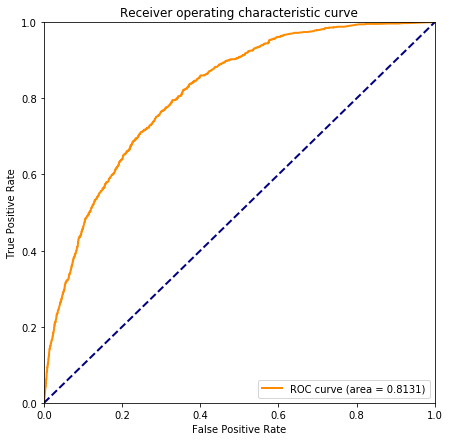

In [70]:
plot_roc_curve(target=y_test, proba=calib_rf_proba_test[:, 1], pos_label=1, figsize=(7, 7))

<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

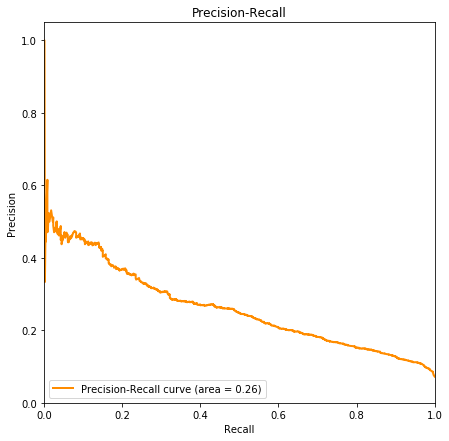

In [71]:
plot_prc_curve(target=y_test, proba=calib_rf_proba_test[:, 1], pos_label=1, average='macro', figsize=(7, 7))

Text(0.5,1,'Calibration curves')

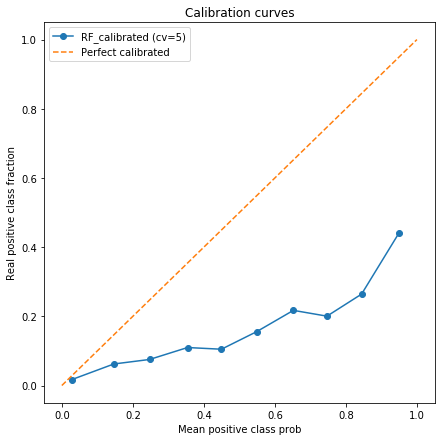

In [93]:
cc_calib_rf_true_pos, cc_calib_rf_pred_pos = calibration_curve(y_test, calib_rf_proba_test[:, 1], n_bins=10)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.plot(cc_calib_rf_pred_pos, cc_calib_rf_true_pos, '-o', label='RF_calibrated (cv=5)', axes=ax)
plt.plot([0, 1], [0, 1], '--', label='Perfect calibrated')
ax.set_xlabel('Mean positive class prob')
ax.set_ylabel('Real positive class fraction')
ax.legend(loc='best')
ax.set_title('Calibration curves')

### Fit RF w/o calibration

In [77]:
pipe_rf = Pipeline(steps=[('pipe_base', pipe_base),
                          ('smote', SMOTE(ratio='auto',
                                          kind='regular',
                                          n_jobs=max_jobs,
                                          random_state=random_state)),
                          ('random_forest', RandomForestClassifier(random_state=random_state,
                                                                   n_jobs=max_jobs,
                                                                   criterion='entropy',
                                                                   class_weight='balanced_subsample',
                                                                   bootstrap=True,
                                                                   oob_score=False,
                                                                   n_estimators=300,
                                                                   max_features='sqrt',
                                                                   max_depth=None,
                                                                   min_samples_leaf=1,
                                                                   min_impurity_decrease=0.0095, )),
                          ],
                   # memory='pipe_cache/'
                   )

In [78]:
t0 = time()
pipe_rf.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))

Predict Time:  62.503602027893066


In [79]:
t0 = time()
pipe_rf_pred_train = pipe_rf.predict(X_train)
pipe_rf_pred_test = pipe_rf.predict(X_test)
pipe_rf_proba_train = pipe_rf.predict_proba(X_train)
pipe_rf_proba_test = pipe_rf.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  12.08644700050354


In [82]:
print('#TRAIN RF#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, pipe_rf_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=pipe_rf_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, pipe_rf_pred_train),
                ks_2samp(y_train, pipe_rf_pred_train)[0],
                ks_2samp(y_train, pipe_rf_pred_train)[1],
                log_loss(y_train, pipe_rf_proba_train[:, 1]), ))

print('\n#TEST RF#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, pipe_rf_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=pipe_rf_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, pipe_rf_pred_test),
                ks_2samp(y_train, pipe_rf_pred_test)[0],
                ks_2samp(y_train, pipe_rf_pred_test)[1],
                log_loss(y_test, pipe_rf_proba_test[:, 1]), ))

#TRAIN RF#
AUC: 0.8181114390816933
F1: 0.3281575156074915
MCC: 0.28336931888294387
KS: D=0.09458307281305067, p-value=8.716490753518217e-206
Log Loss: 0.4716298007092694

#TEST RF#
AUC: 0.8131104057330801
F1: 0.3191025241508258
MCC: 0.2738918393521407
KS: D=0.10104071485537858, p-value=2.97876848964306e-94
Log Loss: 0.47487935835463035


In [94]:
cc_pipe_rf_true_pos, cc_pipe_rf_pred_pos = calibration_curve(y_test, pipe_rf_proba_test[:, 1], n_bins=10)

### Fit LR w calibration

In [105]:
calib_lr = Pipeline(steps=[('pipe_base', pipe_base),
                           ('smote', SMOTE(ratio='auto',
                                           kind='regular',
                                           n_jobs=max_jobs,
                                           random_state=random_state)),
                           ('pca', PCA(n_components='mle',  # n_components=212,
                                       svd_solver='full',
                                       random_state=random_state)),
                           ('logistic_calibrated', CalibratedClassifierCV(
                               base_estimator=LogisticRegression(random_state=random_state,
                                                                 n_jobs=max_jobs,
                                                                 class_weight='balanced',
                                                                 penalty='l2',
                                                                 solver='lbfgs',
                                                                 # solver='sag',  #'saga'
                                                                 max_iter=1000,
                                                                 C=27.0, ),
                               cv=5, method='isotonic')),
                           ],
                    # memory='pipe_cache/'
                    )

In [106]:
t0 = time()
calib_lr.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))

Predict Time:  366.06433868408203


In [107]:
t0 = time()
calib_lr_pred_train = calib_lr.predict(X_train)
calib_lr_pred_test = calib_lr.predict(X_test)
calib_lr_proba_train = calib_lr.predict_proba(X_train)
calib_lr_proba_test = calib_lr.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  10.746530055999756


In [108]:
print('#TRAIN LR CALIBRATED#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, calib_lr_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=calib_lr_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, calib_lr_pred_train),
                ks_2samp(y_train, calib_lr_pred_train)[0],
                ks_2samp(y_train, calib_lr_pred_train)[1],
                log_loss(y_train, calib_lr_proba_train[:, 1]), ))

print('\n#TEST LR CALIBRATED#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, calib_lr_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=calib_lr_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, calib_lr_pred_test),
                ks_2samp(y_train, calib_lr_pred_test)[0],
                ks_2samp(y_train, calib_lr_pred_test)[1],
                log_loss(y_test, calib_lr_proba_test[:, 1]), ))

#TRAIN LR CALIBRATED#
AUC: 0.8574518960509119
F1: 0.3031639501438159
MCC: 0.30659064729323643
KS: D=0.25309308626537075, p-value=0.0
Log Loss: 0.46977881407992095

#TEST LR CALIBRATED#
AUC: 0.8506355447555054
F1: 0.29529946929492035
MCC: 0.29546107303085956
KS: D=0.25769096116079737, p-value=0.0
Log Loss: 0.48473567026322895


In [109]:
cc_calib_lr_true_pos, cc_calib_lr_pred_pos = calibration_curve(y_test, calib_lr_proba_test[:, 1], n_bins=10)

### Fit LR w/o calibration

In [97]:
pipe_lr = Pipeline(steps=[('pipe_base', pipe_base),
                          ('smote', SMOTE(ratio='auto',
                                          kind='regular',
                                          n_jobs=max_jobs,
                                          random_state=random_state)),
                          ('pca', PCA(n_components='mle',  # n_components=212,
                                      svd_solver='full',
                                      random_state=random_state)),
                          ('logistic', LogisticRegression(random_state=random_state,
                                                          n_jobs=max_jobs,
                                                          class_weight='balanced',
                                                          penalty='l2',
                                                          solver='lbfgs',
                                                          # solver='sag',  #'saga'
                                                          max_iter=1000,
                                                          C=27.0, )),
                          ],
                   # memory='pipe_cache/'
                   )

In [98]:
t0 = time()
pipe_lr.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))

Predict Time:  98.45759391784668


In [99]:
t0 = time()
pipe_lr_pred_train = pipe_lr.predict(X_train)
pipe_lr_pred_test = pipe_lr.predict(X_test)
pipe_lr_proba_train = pipe_lr.predict_proba(X_train)
pipe_lr_proba_test = pipe_lr.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  11.066187143325806


In [101]:
print('#TRAIN LR#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, pipe_lr_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=pipe_lr_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, pipe_lr_pred_train),
                ks_2samp(y_train, pipe_lr_pred_train)[0],
                ks_2samp(y_train, pipe_lr_pred_train)[1],
                log_loss(y_train, pipe_lr_proba_train[:, 1]), ))

print('\n#TEST LR#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, pipe_lr_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=pipe_lr_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, pipe_lr_pred_test),
                ks_2samp(y_train, pipe_lr_pred_test)[0],
                ks_2samp(y_train, pipe_lr_pred_test)[1],
                log_loss(y_test, pipe_lr_proba_test[:, 1]), ))

#TRAIN LR#
AUC: 0.8572173688332699
F1: 0.32342149937024256
MCC: 0.31740288799459965
KS: D=0.20385001610489017, p-value=0.0
Log Loss: 0.4770657174018261

#TEST LR#
AUC: 0.8505142964300632
F1: 0.3185457693140013
MCC: 0.3117644283039284
KS: D=0.2080509460035408, p-value=0.0
Log Loss: 0.4905095017811559


In [102]:
cc_pipe_lr_true_pos, cc_pipe_lr_pred_pos = calibration_curve(y_test, pipe_lr_proba_test[:, 1], n_bins=10)

### Fit Voting Classifier

In [112]:
pipe_vc = Pipeline(steps=[('pipe_base', pipe_base),
                          ('smote', SMOTE(ratio='auto',
                                          kind='regular',
                                          n_jobs=max_jobs,
                                          random_state=random_state)),

                          ('VC', VotingClassifier(estimators=[('LR',
                                                               Pipeline(steps=[('pca',
                                                                                PCA(n_components='mle',
                                                                                    # n_components=212,
                                                                                    svd_solver='full',
                                                                                    random_state=random_state)),
                                                                               ('logistic',
                                                                                LogisticRegression(
                                                                                    random_state=random_state,
                                                                                    n_jobs=max_jobs,
                                                                                    class_weight='balanced',
                                                                                    penalty='l2',
                                                                                    solver='lbfgs',
                                                                                    # solver='sag',  #'saga'
                                                                                    max_iter=1000,
                                                                                    C=27.0, )),
                                                                               ])
                                                               ),
                                                              ('RF_calibrated', CalibratedClassifierCV(
                                                                  base_estimator=RandomForestClassifier(
                                                                      random_state=random_state,
                                                                      n_jobs=max_jobs,
                                                                      criterion='entropy',
                                                                      class_weight='balanced_subsample',
                                                                      bootstrap=True,
                                                                      oob_score=False,
                                                                      n_estimators=300,
                                                                      max_features='sqrt',
                                                                      max_depth=None,
                                                                      min_samples_leaf=1,
                                                                      min_impurity_decrease=0.0095, ),
                                                                  cv=5, method='isotonic')),
                                                              ],
                                                  voting='soft',
                                                  weights=None,
                                                  n_jobs=max_jobs,
                                                  flatten_transform=None, )),
                          ],
                   # memory='pipe_cache/'
                   )

In [113]:
t0 = time()
pipe_vc.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))

Fit Time:  223.37861847877502


In [114]:
t0 = time()
pipe_vc_pred_train = pipe_vc.predict(X_train)
pipe_vc_pred_test = pipe_vc.predict(X_test)
pipe_vc_proba_train = pipe_vc.predict_proba(X_train)
pipe_vc_proba_test = pipe_vc.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  18.93529224395752


In [115]:
print('#TRAIN VC#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, pipe_vc_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=pipe_vc_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, pipe_vc_pred_train),
                ks_2samp(y_train, pipe_vc_pred_train)[0],
                ks_2samp(y_train, pipe_vc_pred_train)[1],
                log_loss(y_train, pipe_vc_proba_train[:, 1]), ))

print('\n#TEST VC#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, pipe_vc_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=pipe_vc_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, pipe_vc_pred_test),
                ks_2samp(y_train, pipe_vc_pred_test)[0],
                ks_2samp(y_train, pipe_vc_pred_test)[1],
                log_loss(y_test, pipe_vc_proba_test[:, 1]), ))

#TRAIN LR#
AUC: 0.8517697991911303
F1: 0.34958950249105325
MCC: 0.32228912345268057
KS: D=0.1278728282081889, p-value=0.0
Log Loss: 0.37147277559712477

#TEST LR#
AUC: 0.8458728513866058
F1: 0.33471188309897987
MCC: 0.30446257631356843
KS: D=0.13271938101680336, p-value=2.61290874157152e-162
Log Loss: 0.3820559174435313


<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

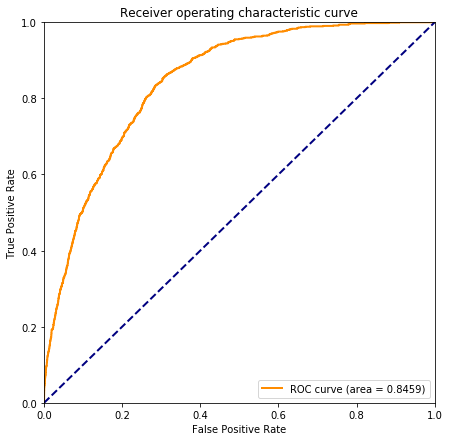

In [120]:
plot_roc_curve(target=y_test, proba=pipe_vc_proba_test[:, 1], pos_label=1, figsize=(7, 7))

<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

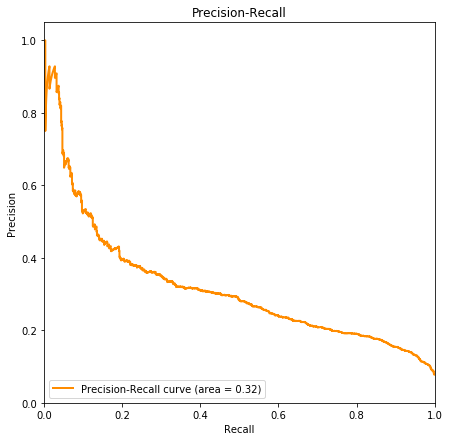

In [121]:
plot_prc_curve(target=y_test, proba=pipe_vc_proba_test[:, 1], pos_label=1, average='macro', figsize=(7, 7))

In [117]:
cc_pipe_vc_true_pos, cc_pipe_vc_pred_pos = calibration_curve(y_test, pipe_vc_proba_test[:, 1], n_bins=10)

### Learning curve

In [122]:
t0 = time()
lc_vc_train_sizes, lc_vc_train_scores, lc_vc_test_scores = learning_curve(estimator=pipe_vc, X=X_test, y=y_test,
                                                                          cv=inner_cv, n_jobs=max_jobs,
                                                                          scoring='roc_auc',
                                                                          train_sizes=np.linspace(0.1, 1.0, 5))
print('Fit Time: ', (time() - t0))

Fit Time:  232.11148834228516


<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

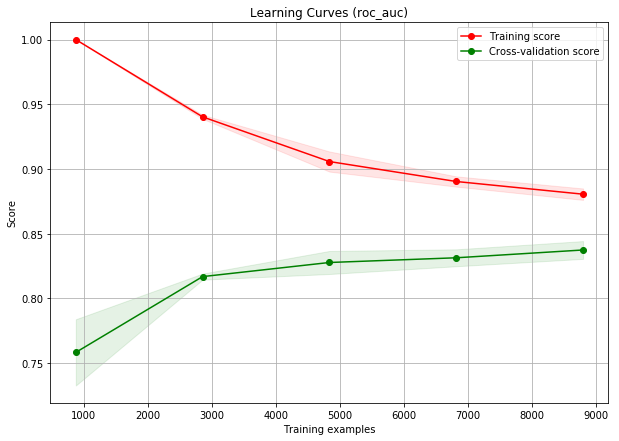

In [123]:
plot_learning_curve(train_sizes=lc_vc_train_sizes, train_scores=lc_vc_train_scores, test_scores=lc_vc_test_scores,
                    title='Learning Curves (roc_auc)', ylim=None, figsize=(10, 7))

### Plot calibration curves

Text(0.5,1,'Calibration curves')

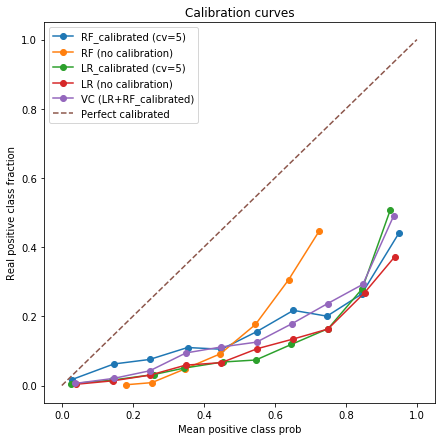

In [118]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.plot(cc_calib_rf_pred_pos, cc_calib_rf_true_pos, '-o', label='RF_calibrated (cv=5)', axes=ax)
plt.plot(cc_pipe_rf_pred_pos, cc_pipe_rf_true_pos, '--o', label='RF (no calibration)', axes=ax)
plt.plot(cc_calib_lr_pred_pos, cc_calib_lr_true_pos, '-o', label='LR_calibrated (cv=5)', axes=ax)
plt.plot(cc_pipe_lr_pred_pos, cc_pipe_lr_true_pos, '--o', label='LR (no calibration)', axes=ax)
plt.plot(cc_pipe_vc_pred_pos, cc_pipe_vc_true_pos, '-o', label='VC (LR+RF_calibrated)', axes=ax)
plt.plot([0, 1], [0, 1], '--o', label='Perfect calibrated')
ax.set_xlabel('Mean positive class prob')
ax.set_ylabel('Real positive class fraction')
ax.legend(loc='best')
ax.set_title('Calibration curves')